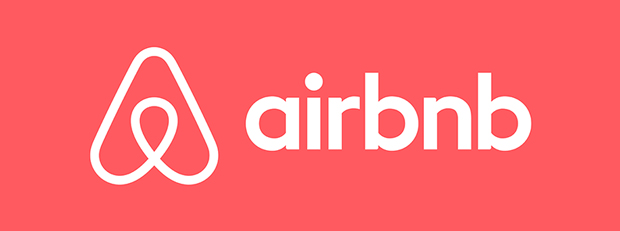

In [101]:
Image(filename = 'airbnb_logo2.jpg', width=900, height=100)

# Team AirbnbAdvisor
### Team member: Wenshan Liang, Zhengchen Lv, Wenjie Wang, Xinxin Wang, Xinran Zhang

In [90]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [ ]:
import nltk
#nltk.download()

# Loading Raw Data

### listings

In [63]:
listings = pd.read_csv('listings.csv')
listings.columns

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

### reviews

In [65]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2515,198,2008-10-13,2603,Jenny,Stephanie was a wonderful host! Her apartment ...
1,2515,859,2009-03-08,8455,Roland,Such a wonderful place and very close to the m...
2,2515,1083,2009-03-25,9759,Cem,I just got back from a trip to NYC during whic...
3,2515,1107,2009-03-27,9193,Holly,Stephanie's offered all the most important thi...
4,2515,2175,2009-05-09,7048,Alessandra,"Stephanie was really nice, ftiendly and helpfu..."


# Data preprocessing

### geography related dataset

In [66]:
df_geo = pd.DataFrame(columns=['listing_id','latitude','longitude',
                           'zipcode','borough'])

df_geo['listing_id'] = listings['id']
df_geo['latitude'] = listings['latitude'].astype('float',copy=False)
df_geo['longitude'] = listings['longitude'].astype('float',copy=False)
df_geo.columns

Index(['listing_id', 'latitude', 'longitude', 'zipcode', 'borough'], dtype='object')

In [ ]:
# check values of each col
print(df_geo['longitude'].isnull().sum())
print(df_geo['latitude'].isnull().sum())

# zip code cannot be used because of too many missing values & wrong values
print(df_geo['zipcode'].isnull().sum())

# each listing id is an unique primary key
print(len(df_geo['listing_id'].unique()))

In [ ]:
! pip install uszipcode

In [ ]:
# remap zip code for each row
from uszipcode import SearchEngine
from uszipcode import Zipcode
search = SearchEngine(simple_zipcode=True)

for i in range(len(df_geo)):
    lat = df_geo.loc[i,'latitude']
    lng = df_geo.loc[i,'longitude']
    result = search.by_coordinates(lat, lng, radius=30, returns=1)
    df_geo.loc[i,'zipcode'] = result[0].zipcode

# save zip code data
df_geo.to_csv('dataframe_geography.csv')

In [ ]:
# load and process zipcode-suborough-borough mapping dataframe
df_bor = pd.read_excel('borough.xlsx')
df_bor['zip_list'] = df_bor['zipcode'].astype(str,copy=False).str.split(',')

df_area = pd.DataFrame(columns = ['zipcode','sub_borough','borough'])
for index in range(len(df_bor)):
    a = df_bor.loc[index,'borough']
    b = df_bor.loc[index,'sub_borough']
    for i in range(len(df_bor.loc[index,'zip_list'])):
        c = df_bor.loc[index,'zip_list'][i]
        df_area = df_area.append({'zipcode':c,'sub_borough':b,'borough':a},ignore_index=True)

# save geo_map df
df_area.to_csv('geo_map.csv')

In [ ]:
# join geo dataframe with map dataframe
df_geo = pd.read_csv('dataframe_geography.csv',index_col = ['Unnamed: 0'])
df_map = pd.read_csv('geo_map.csv',index_col = ['Unnamed: 0'])
df_geo.drop('borough',axis=1,inplace=True)
df_geo = df_geo.set_index('zipcode').join(df_map.set_index('zipcode'),on = 'zipcode')

# save new joined dataframe into new geo df
df_geo = df_geo.loc[df_geo['sub_borough'].isnull() == False]
df_geo.to_csv('dataframe_geography.csv')

### review related dataset

In [ ]:
# drop reviews with no comments
reviews = reviews[reviews['comments'].isnull()==False]
reviews.reset_index(drop=True,inplace=True)

# consolidate reviews
dict_rev = dict()
for i in range(len(reviews)):
    listing_id = reviews.loc[i,'listing_id']
    if dict_rev.get(str(listing_id)) == None:
        dict_rev[str(listing_id)] = reviews.loc[i,'comments']
    else:
        dict_rev[str(listing_id)] = dict_rev[str(listing_id)] + reviews.loc[i,'comments']

# change dict to dataframe and save
reviews_text = pd.DataFrame.from_dict(dict_rev,orient = 'index',columns = ['review_text'])
reviews_text.to_csv('review_text.csv')

# Sub-borough Based General Analaysis

- Number of listings
- Distribution of room-type information
    - ????

## Number of listings per sub-borough

In [ ]:
df_general = pd.read_csv('dataframe_geography.csv',index_col=['Unnamed: 0'])

# group by sub-boroughs
grouped = df_general.groupby(['sub_borough'])

# check number of listings per borough and sub-borough 
listing_num = pd.DataFrame(grouped.size(),columns=['listing_num'])
grouped_df = pd.DataFrame(listing_num)

# Sort dataframe by index value
grouped_df = grouped_df.sort_index()

# Analysis with Google API

- Restaurant ratings around lisitings
- Museum ratings around lisitings

# Text mining

## Text mining data processing

### prepare dataset for text mining

In [ ]:
# read from prepared data
reviews_text = pd.read_csv('review_text.csv')
df_geo = pd.read_csv('dataframe_geography.csv',index_col = ['Unnamed: 0'])

# join review texts with geo map
df_review = df_geo.set_index('listing_id').join(reviews_text.set_index('listing_id'),on = 'listing_id')
df_review.drop(labels='index',axis=1,inplace=True)
df_review.reset_index(inplace=True)

# drop listing_id with no reviews
df_review = df_review[df_review['review_text'].isnull()==False]

df_review.to_csv('review_for_text_mining.csv')

### select sample review_data per listing

In [3]:
df_review = pd.read_csv('review_for_text_mining.csv',index_col=['Unnamed: 0'])
df_review.reset_index(drop=True,inplace=True)

In [5]:
def get_sample_df(df_review,sample_size):
    # initiate sample dataframe
    review_sample_df = pd.DataFrame(columns=df_review.columns)

    # prepare list of sub-boroughs & list count
    sub_bor_list = list(df_review['sub_borough'].unique())
    count_dict = dict()
    for subbor in sub_bor_list:
        count_dict[subbor] = 0

    for i in range(len(df_review)):
        sub_bor = df_review.loc[i,'sub_borough']
        if count_dict[sub_bor] < sample_size:
            review_sample_df = review_sample_df.append(df_review.iloc[i])
            count_dict[sub_bor] += 1
    
    review_sample_df.reset_index(inplace=True,drop=True)
    return review_sample_df

# given sample size per sub-borough
sample_size = 100
review_sample_df = get_sample_df(df_review,sample_size)
review_sample_df.to_csv('review_sample_subborough_df.csv')

### prepare review_text per borough

In [ ]:
review_bor_dict = dict()
#bor_list = ['Manhattan','Brooklyn','Queens','Bronx']
for i in range(len(df_review)):
    if review_bor_dict.get(df_review.loc[i,'borough']) == None:
        review_bor_dict[df_review.loc[i,'borough']] = df_review.loc[i,'review_text']
    else:
        review_bor_dict[df_review.loc[i,'borough']] += df_review.loc[i,'review_text']

review_bor_df = pd.DataFrame.from_dict(review_bor_dict,orient ='index')
review_bor_df.columns = ['review_bor']
review_bor_df.to_csv('review_bor_df.csv')

### clean text and change format of text data into text_list for text analysis 

In [ ]:
# load data review_text per borough
review_bor_df = pd.read_csv('review_bor_df.csv')
review_bor_df.columns = ['borough','review_text']

In [3]:
# review_bor_df to review_bor_list
review_bor_list = []
for i in range(len(review_bor_df)):
    bor = review_bor_df.loc[i,'borough']
    review = review_bor_df.loc[i,'review_text']
    review_bor_list.append((bor,review))

In [ ]:
# load sample data review_text per sub-borough
review_sample_df_raw = pd.read_csv('review_sample_subborough_df.csv',index_col=['Unnamed: 0'])
review_sample_df = review_sample_df_raw[['listing_id','review_text']]

# review_sample_df to review_sample_list
review_sample_list = []
for i in range(len(review_sample_df)):
    listing_id = review_sample_df.loc[i,'listing_id']
    review = review_sample_df.loc[i,'review_text']
    
    # text cleaning of review sample data
    review.replace('\n','')
    review.replace('*','')
    review.replace('..','.')
    review.replace('?','')
    review_sample_df.loc[i,'review_text'] = review
        
    review_sample_list.append((listing_id,review))

## Naive sentiment analysis

In [ ]:
# naive sentiment analysis - functions
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        #print(word_list)
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()
from nltk import word_tokenize

def do_pos_neg_sentiment_analysis(positive_words,negative_words,text_list,debug=False):
    results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1].decode('utf-8', 'ignore')):
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((text[0],float(cpos)/len(word_tokenize(text[1].decode('utf-8', 'ignore'))),
                        float(cneg)/len(word_tokenize(text[1].decode('utf-8', 'ignore')))))
    return results

In [140]:
naive_result = do_pos_neg_sentiment_analysis(positive_words,negative_words,review_sample_list,debug=False)
naive_result_df = pd.DataFrame(naive_result,columns=['listing_id','postive','negative'])
naive_result_df.to_csv('naive_sentiment_analysis_result.csv')

## NRC Sentiment Analysis

In [155]:
#preparing the NRC emotion dictionary
nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
count=0
emotion_dict=dict()
with open(nrc,'r') as f:
    all_lines = list()
    for line in f:
        if count < 46:
            count+=1
            continue
        line = line.strip().split('\t')
        if int(line[2]) == 1:
            if emotion_dict.get(line[0]):
                emotion_dict[line[0]].append(line[1])
            else:
                emotion_dict[line[0]] = [line[1]]

def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0

    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in text.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1.0/len(text.split())
    return emotion_count

In [156]:
# a function that analyzes the emotional content of the review texts
def comparative_emotion_analyzer(text_tuples,object_name="listing_id",print_output=False):
    if print_output:
        print("%-20s %1s\t%1s %1s %1s %1s   %1s %1s %1s %1s"%(object_name,
                                                              "fear","trust","negative","positive",
                                                              "joy","disgust","anticip", "sadness",
                                                              "surprise"))
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:#
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        if print_output:
            print("%-20s %1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f"%(
                text_tuple[1][0:20],result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']))
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output

In [168]:
NRC_result = comparative_emotion_analyzer(review_sample_list)
NRC_result.to_csv('NRC_sentiment_analysis_result.csv')

## Vadar Sentiment Analysis

In [ ]:
!pip install vaderSentiment

In [18]:
def vader_comparison(col_name,texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from nltk import sent_tokenize, word_tokenize
    vadar_df = pd.DataFrame(columns=[col_name,'positive','negative','neutral','compound'])
    analyzer = SentimentIntensityAnalyzer()
    for i in range(len(texts)):
        name = texts[i][0]
        sentences = sent_tokenize(texts[i][1])
        pos=compound=neu=neg=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            pos+=vs['pos']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
            neu+=vs['neu']/(len(sentences))
            neg+=vs['neg']/(len(sentences))
        vadar_df = vadar_df.append({col_name:name,'positive':pos,
                                    'negative':neg,'neutral':neu,'compound':compound},ignore_index=True)
    return vadar_df

In [32]:
vadar_result = vader_comparison('listing_id',review_sample_list)
vadar_result.to_csv('vadar_sentiment_analysis_result.csv')

## Word Cloud

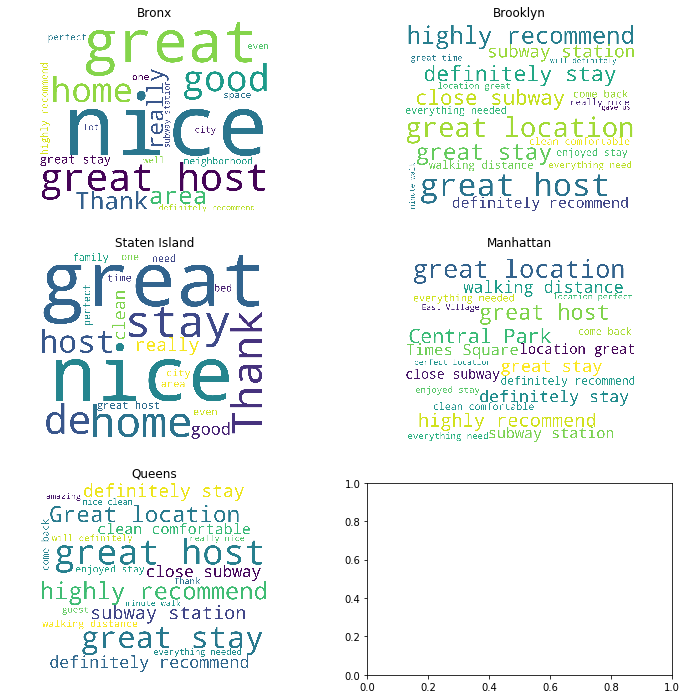

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#Remove unwanted words
#As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
DELETE_WORDS = ['room','apartment','house','place','New York','NYC',
                'Staten Island', 'Bronx','Manhattan','Brooklyn','Queens']
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+ word +' ',' ',1)
    return text_string

#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(len(review_bor_list)):
    text_string = remove_words(review_bor_list[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(review_bor_list[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',
                          width=1200,height=1000,max_words=20).generate(text_string)
    # save wordcloud image to file
    image_name = review_bor_list[i][0] + '_wordcloud.png'
    wordcloud.to_file(image_name)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

## Text mining results analysis

In [68]:
# vadar result
vadar_result_all = pd.read_csv('vadar_all_reviews_result.csv',index_col='Unnamed: 0')
vadar_result_all.set_index('listing_id',drop=True,inplace=True)
vadar_result_all.columns = ['vadar_positive','vadar_negative','vadar_neutral','vadar_compound']
vadar_result_all.head()

,vadar_positive,vadar_negative,vadar_neutral,vadar_compound
listing_id,,,,
2515.0,0.221300,0.019026,0.759676,0.365536
2539.0,0.290750,0.009437,0.699812,0.499075
3330.0,0.245543,0.008633,0.745824,0.448850
3831.0,0.214805,0.018656,0.766537,0.363554
5022.0,0.245000,0.005852,0.749148,0.441030


In [70]:
# NRC result
NRC_result_all = pd.read_csv('NRC_all_reviews_result.csv')
NRC_result_all.set_index('listing_id',drop=True,inplace=True)
NRC_result_all.columns = ['NRC_Fear', 'NRC_Trust', 'NRC_Negative', 'NRC_Positive', 'NRC_Joy', 'NRC_Disgust',
       'NRC_Anticipation', 'NRC_Sadness', 'NRC_Surprise']
NRC_result_all.head()

,NRC_Fear,NRC_Trust,NRC_Negative,NRC_Positive,NRC_Joy,NRC_Disgust,NRC_Anticipation,NRC_Sadness,NRC_Surprise
listing_id,,,,,,,,,
2515,0.003098,0.023872,0.006651,0.034077,0.018405,0.001549,0.015216,0.005194,0.007016
2539,0.000000,0.038647,0.000000,0.062802,0.028986,0.000000,0.028986,0.009662,0.009662
3330,0.001009,0.030272,0.005045,0.044063,0.026236,0.001009,0.020518,0.004373,0.008745
3831,0.003785,0.024736,0.005898,0.038644,0.019894,0.001585,0.019014,0.005634,0.008627
5022,0.006897,0.016092,0.006897,0.032184,0.011494,0.000000,0.016092,0.006897,0.009195


In [ ]:
????

# Machine learning

- Borough recommendations
- Classification model based on a list of features of every listings

### general data prepration and cleaning

In [ ]:
listings = pd.read_csv('listings.csv')
model_df_raw = pd.read_csv('dataframe_geography.csv',index_col=['Unnamed: 0'])
listing_features = listings[[
    'id',
    'host_since',
    'host_is_superhost',
    'host_listings_count',
    'host_has_profile_pic',
    'host_identity_verified',
    'is_location_exact',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'bed_type',
    'price',
    'cleaning_fee',
    'guests_included',
    'extra_people',
    'minimum_nights',
    'maximum_nights',
    'availability_30',
    'availability_60',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'instant_bookable',
    'require_guest_profile_picture',
    'require_guest_phone_verification',
]]

In [4]:
def clean_data(listing_features,model_df_raw,analysis=False):
    # map listings features to available listings
    model_df = model_df_raw.set_index('listing_id',drop=True).join(listing_features.set_index('id',drop=True))
    
    if not analysis:
        # drop location related features
        model_df = model_df.drop(['index','zipcode','latitude','longitude','sub_borough'],axis=1)

        print('Data cleaning for y values:\n')
        # map boroughs into numbers
        model_df['borough'] = np.where(model_df['borough']=='Manhattan',1,
                          np.where(model_df['borough']=='Brooklyn',2,
                          np.where(model_df['borough']=='Queens',3,
                          np.where(model_df['borough']=='Bronx',4,5))))
                          #np.where(model_df['borough']=='Staten Island'

        # check y value
        print('Borough id:',model_df['borough'].unique(),'\n')

    print('\nData cleaning for feature columns values:\n')

    # replace True/Fasle values with 0/1
    model_df.replace('f',0,inplace=True)
    model_df.replace('t',1,inplace=True)

    # drop rows with missing host related values
    model_df = model_df[~model_df['host_is_superhost'].isnull()]

    # change host_since column to number of host years
    model_df['host_year_num'] = model_df['host_since'].apply(lambda x:2018-int(x[:4]))
    model_df.drop(['host_since'],axis=1, inplace=True)
    
    #data cleaning for property type
    if analysis:
        property_list = ['Apartment', 'Guest suite', 'House', 'Condominium', 'Loft',
               'Townhouse', 'Bed and breakfast', 'Boutique hotel', 'Tiny house',
               'Guesthouse', 'Serviced apartment', 'Other', 'Resort', 'Boat',
               'Hotel', 'Aparthotel', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
               'Villa', 'Cave', 'Nature lodge', 'Houseboat', 'Cabin', 'Castle',
               'Train', 'Timeshare', 'Camper/RV', 'Casa particular (Cuba)']
    else:
        # only select common property types
        property_list = []
        for i in list(model_df['property_type'].unique()):
            if sum(model_df['property_type']== i)>200:
                property_list.append(i)
    
    for i in range(len(property_list)):
        model_df['property_type'].mask(model_df['property_type']==property_list[i],i+1,inplace=True)
        print('Property Type ID:',i+1,' Property Name:',property_list[i])
    if not analysis:
        # map all others into one category
        model_df['property_type'].where(model_df['property_type'].map(type)==int,i+2,inplace=True)
        print('Property Type ID:',i+2,' Property Name:','Others')
        # drop rows with low-volume property types 
        #model_df = model_df[model_df['property_type'].map(type)==int]
    model_df['property_type'] = model_df['property_type'].astype('int')
    
    # data cleaning for room type
    print('\n')
    room_list = ['Private room', 'Entire home/apt', 'Shared room']
    for i in range(len(room_list)):
        model_df['room_type'].mask(model_df['room_type']==room_list[i],i+1,inplace=True)
        print('Room Type ID:',i+1,' Room Type Name:',room_list[i])
    model_df['room_type'] = model_df['room_type'].astype('int')

    # data cleaning for bed type
    print('\n')
    bed_list = ['Real Bed', 'Pull-out Sofa', 'Futon', 'Couch', 'Airbed']
    for i in range(len(bed_list)):
        model_df['bed_type'].mask(model_df['bed_type']==bed_list[i],i+1,inplace=True)
        print('Bed Type ID:',i+1,' Bed Type Name:',bed_list[i])
    model_df['bed_type'] = model_df['bed_type'].astype('int')

    # data cleaning of price
    model_df['price'] = model_df['price'].apply(lambda x:float(x.replace(',','')[1:]))
    # calculate price per accommodate
    model_df['price'] = model_df['price']/model_df['accommodates']

    # cleaning fee - turn Not NaN to float
    model_df.loc[~model_df['cleaning_fee'].isnull(),'cleaning_fee'] = model_df['cleaning_fee'][~model_df['cleaning_fee'].isnull()].apply(lambda x:float(x.replace(',','')[1:]))
    # take average of cleaning fee to fill na
    model_df['bed_type'] = model_df['bed_type'].astype('float')
    model_df['cleaning_fee'].fillna(model_df['cleaning_fee'].mean(),inplace=True)
    # calculate cleaning fee per accommodate
    model_df['cleaning_fee'] = model_df['cleaning_fee']/model_df['accommodates']
    
    # data cleaning of extra people fee
    model_df['extra_people'] = model_df['extra_people'].apply(lambda x:float(x.replace(',','')[1:]))
    
    # fillna of bedrooms and bedrooms with 1
    model_df['bedrooms'].fillna(1,inplace=True)
    model_df['bathrooms'].fillna(1,inplace=True)
    return model_df

In [20]:
# for building model with basic features
model_df = clean_data(listing_features,model_df_raw,analysis=False)
model_df.to_csv('df_for_model.csv')

Data cleaning for y values:

Borough id: [1 2 3 4 5] 


Data cleaning for feature columns values:

Property Type ID: 1  Property Name: Apartment
Property Type ID: 2  Property Name: Guest suite
Property Type ID: 3  Property Name: House
Property Type ID: 4  Property Name: Condominium
Property Type ID: 5  Property Name: Loft
Property Type ID: 6  Property Name: Townhouse
Property Type ID: 7  Property Name: Serviced apartment
Property Type ID: 8  Property Name: Others


Room Type ID: 1  Room Type Name: Private room
Room Type ID: 2  Room Type Name: Entire home/apt
Room Type ID: 3  Room Type Name: Shared room


Bed Type ID: 1  Bed Type Name: Real Bed
Bed Type ID: 2  Bed Type Name: Pull-out Sofa
Bed Type ID: 3  Bed Type Name: Futon
Bed Type ID: 4  Bed Type Name: Couch
Bed Type ID: 5  Bed Type Name: Airbed


In [ ]:
model_df.info()

In [ ]:
# for general analysis
analysis_df = clean_data(listing_features,model_df_raw,analysis=True)
analysis_df.to_csv('df_for_analysis.csv')

### Consolidate text mining &API results into dataset

In [73]:
# join vadar features
model_df = model_df.join(vadar_result_all)

#join NRC features
model_df = model_df.join(NRC_result_all)

# join restaurant and meusums features
museum_rest_rating = pd.read_csv('museum_rest_rating.csv',index_col=['Unnamed: 0'])
museum_rest_rating.set_index(['listing_id'],drop=True,inplace=True)
model_df = model_df.join(museum_rest_rating)

model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47098 entries, 2515 to 28987870
Data columns (total 48 columns):
borough                             47098 non-null int64
host_is_superhost                   47098 non-null float64
host_listings_count                 47098 non-null float64
host_has_profile_pic                47098 non-null float64
host_identity_verified              47098 non-null float64
is_location_exact                   47098 non-null int64
property_type                       47098 non-null int64
room_type                           47098 non-null int64
accommodates                        47098 non-null int64
bathrooms                           47098 non-null float64
bedrooms                            47098 non-null float64
beds                                47034 non-null float64
bed_type                            47098 non-null float64
price                               47098 non-null float64
cleaning_fee                        47098 non-null float64
guests_included

### feature correlation matrix

In [22]:
import seaborn as sns
def plot_corr(df):
    f, ax = plt.subplots(figsize=(20,16))
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    return sns.heatmap(corr, mask=mask,
                cmap=sns.palplot(sns.cubehelix_palette(8)),square=True,ax=ax)

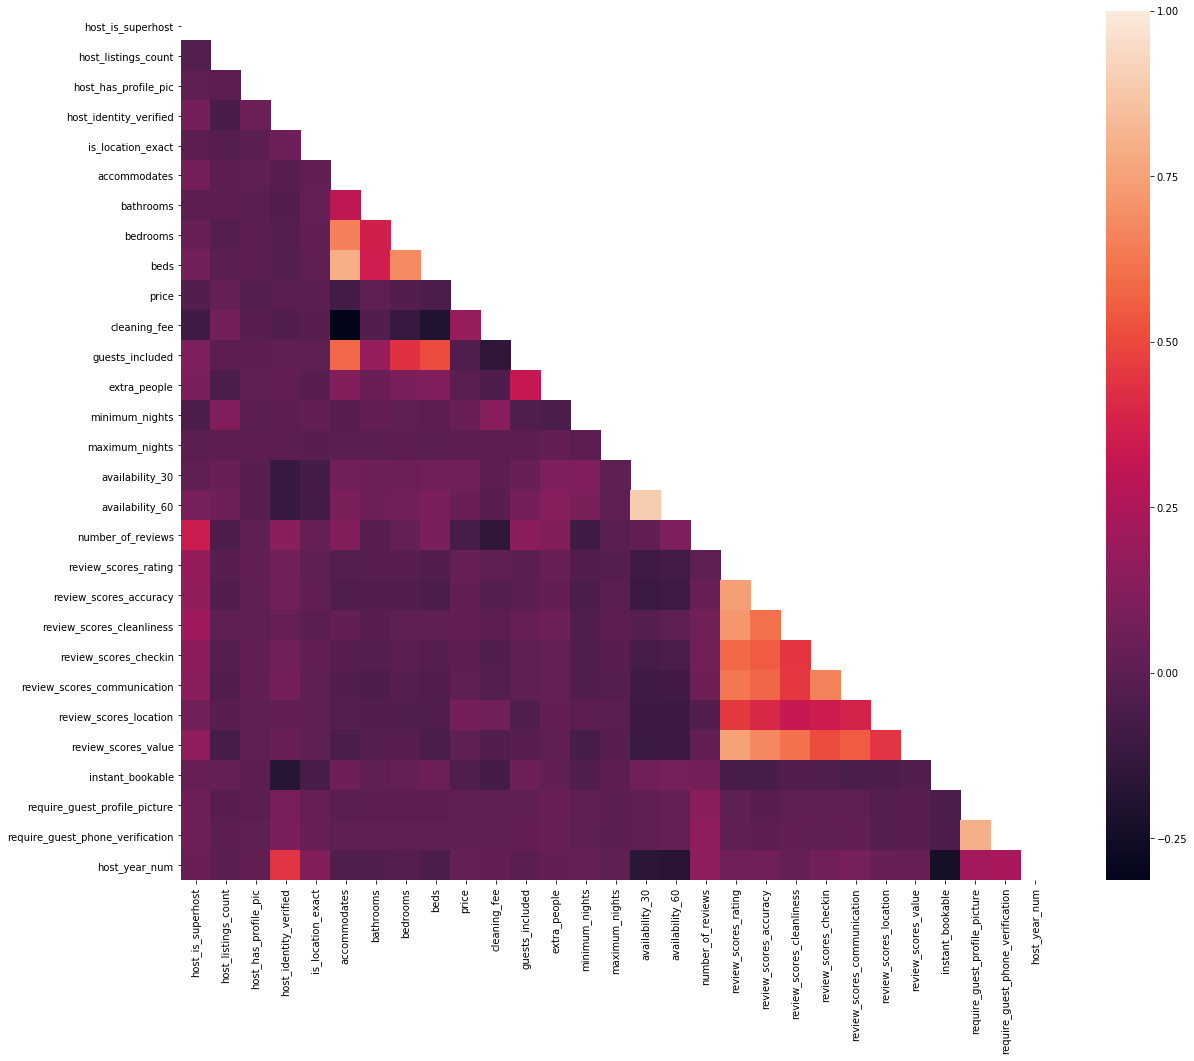

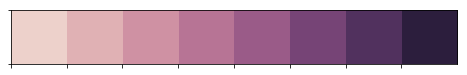

In [479]:
# correlation matrix for general features
plot_corr(model_df.drop(['borough','property_type','room_type','bed_type'],axis=1))

In [ ]:
# correlation matrix for all features
plot_corr(model_df.drop(['borough','property_type','room_type','bed_type'],axis=1))

## Dataset modification
- One Hot Encoding (OHE)
- Feature normalization
- Generation of train set and test set

In [24]:
def one_hot_encoding(model_df):
    one_hot_room = pd.get_dummies(model_df['room_type'])
    one_hot_room.columns = ['Private room', 'Entire home/apt', 'Shared room']
    
    one_hot_property = pd.get_dummies(model_df['property_type'])
    one_hot_property.columns = ['Apartment','Guest suite','House','Condominium','Loft','Townhouse','Serviced apartment','Others']

    one_hot_bed = pd.get_dummies(model_df['bed_type'])
    one_hot_bed.columns = ['Real Bed', 'Pull-out Sofa', 'Futon', 'Couch', 'Airbed']
    
    model_df = model_df.join(one_hot_room).join(one_hot_bed).join(one_hot_property)
    model_df.drop(['room_type','property_type','bed_type'],axis=1,inplace=True)
    
    return model_df

one_hot_model = one_hot_encoding(model_df)
# total 61 columns
one_hot_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47098 entries, 2515 to 28987870
Data columns (total 61 columns):
borough                             47098 non-null int64
host_is_superhost                   47098 non-null float64
host_listings_count                 47098 non-null float64
host_has_profile_pic                47098 non-null float64
host_identity_verified              47098 non-null float64
is_location_exact                   47098 non-null int64
accommodates                        47098 non-null int64
bathrooms                           47098 non-null float64
bedrooms                            47098 non-null float64
beds                                47034 non-null float64
price                               47098 non-null float64
cleaning_fee                        47098 non-null float64
guests_included                     47098 non-null int64
extra_people                        47098 non-null float64
minimum_nights                      47098 non-null int64
maximum_nights 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler

def get_machine_learning_dataset(model_df,training_percent=0.7,normalize=False):
    train, test = train_test_split(model_df, test_size = 0.3)
    x_train = train.drop(['borough'],axis=1)
    y_train = train['borough']
    x_test = test.drop(['borough'],axis=1)
    y_test = test['borough']
    if normalize:
        x_train = StandardScaler().fit_transform(x_train)
        x_test = StandardScaler().fit_transform(x_test)
    return x_train,y_train,x_test,y_test

## Model testing

- Model type:
    - Random forest
    - Logistic regression
    - SVM
- Input dataset
    - Raw model as input
    - Drop all missing values (20%-25%) - drop review related data
    - Drop feature columns with missing values


### Decision tree based classification

In [26]:
import pydotplus 
from IPython.display import Image

def decision_tree(df,max_depth=5):
    x_train,y_train,x_test,y_test = get_machine_learning_dataset(df)
    model = tree.DecisionTreeClassifier(max_depth=max_depth,criterion='entropy')
    model.fit(x_train,y_train)
    feature_names = x_train.columns
    dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names) 
    graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
    score = model.score(x_test,y_test)
    print('Simple decision tree accuracy:',score)
    return model,graph,score

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def random_forest_GridSearchCV(df,parameters):
    x_train,y_train,x_test,y_test = get_machine_learning_dataset(df)
    model = GridSearchCV(RandomForestClassifier(),parameters,cv=3,iid=False)
    model.fit(x_train, np.ravel(y_train))
    return model,model.best_score_, model.best_params_

In [28]:
def random_forest(df,n_estimators=20,max_depth=10,min_samples_split=2,min_samples_leaf=4):
    x_train,y_train,x_test,y_test = get_machine_learning_dataset(df)
    model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
    model.fit(x_train,np.ravel(y_train))
    score = model.score(x_test,y_test)
    print('Random forest accuracy:',score)
    print('Parameters:\nn_estimators:',n_estimators,'\nmax_depth:',max_depth,
          '\nmin_samples_split:',min_samples_split,'\nmin_samples_leaf:',min_samples_leaf)
    return model,score

### Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def logistic_regression(df):
    x_train,y_train,x_test,y_test = get_machine_learning_dataset(df,normalize=True)
    model=LogisticRegression()
    model.fit(x_train,y_train)
    score = metrics.accuracy_score(y_test,model.predict(x_test))
    print('Logistic regression accuracy:',score)
    return model,score

### SVM (Support Vector Machine)

In [105]:
from sklearn import svm

def Support_Vector_Machine(df,kernel='rbf',C=5):
    x_train,y_train,x_test,y_test = get_machine_learning_dataset(df,normalize=False)
    model = svm.SVC(C=C, kernel=kernel, gamma='auto')
    model.fit(x_train,y_train)
    score = model.score(x_test,y_test)
    print('Support Vecotor Machine accuracy:',score)
    print('kernel:',kernel)
    print('C:',C)
    return model,score

In [ ]:
### 

## Test different models

### test 1: data contains review scores as input

Simple decision tree accuracy: 0.6274581878331189


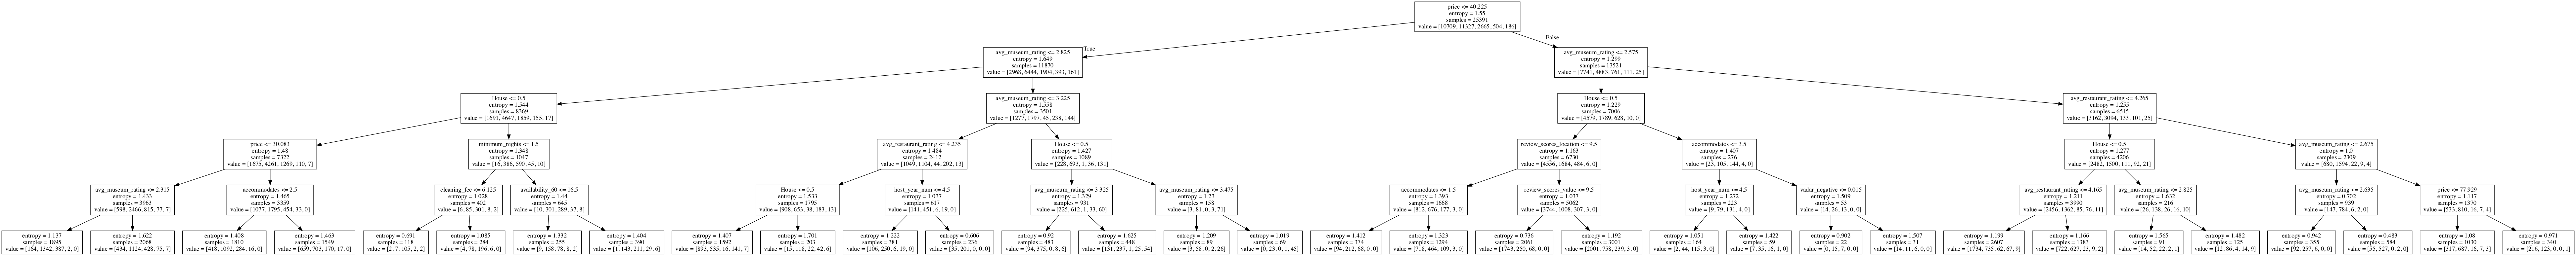

In [30]:
# test 1: drop all missing values - only maintain data with review
model_df_1 = one_hot_model.dropna()

model_tree,graph,score_tree = decision_tree(model_df_1,max_depth=5)
Image(graph.create_png())

In [34]:
# to find the best set of parameters 
parameters = {
     'n_estimators':range(30,50,10),
     'max_depth':range(20,35,5),
     'min_samples_split': (16,32,64),
     'min_samples_leaf': range(4,16,4)}
    
model_RF_GridSearchCV,score_RF_GridSearchCV, parameter_RF_GridSearchCV = random_forest_GridSearchCV(model_df_1,parameters)
model_RF_GridSearchCV,score_RF_GridSearchCV, parameter_RF_GridSearchCV

# Best set of parameters:
# 'n_estimators': 40
# 'max_depth': 25
# 'min_samples_split': 16
# 'min_samples_leaf': 8

(GridSearchCV(cv=3, error_score='raise',
        estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
        fit_params=None, iid=False, n_jobs=1,
        param_grid={'n_estimators': range(30, 50, 10), 'max_depth': range(20, 35, 5), 'min_samples_split': (16, 32, 64), 'min_samples_leaf': range(4, 16, 4)},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0),
 0.6845732178039103,
 {'max_depth': 25,
  'min_samples_leaf': 8,
  'min_samples_split': 16,
  'n_estimators': 40})

In [80]:
model_RF1,score_RF1 = random_forest(model_df_1,n_estimators=40,max_depth=20,min_samples_split=16,min_samples_leaf=8)
print('\n')
model_LR1,score_LR1 = logistic_regression(model_df_1)

Random forest accuracy: 0.6927954420143356
Parameters:
n_estimators: 40 
max_depth: 20 
min_samples_split: 16 
min_samples_leaf: 8


Logistic regression accuracy: 0.6284690314280463


In [ ]:
model_SVM1,score_SVM1 = Support_Vector_Machine(model_df_1,'rbf',10)

### test 2: keep dataframe with missing values - substitute with 0

In [39]:
model_df_2 = one_hot_model.fillna(0)

model_RF2,score_RF2 = random_forest(model_df_2,n_estimators=40,max_depth=20,min_samples_split=16,min_samples_leaf=16)
print('\n')
model_LR2,score_LR2 = logistic_regression(model_df_2)

Random forest accuracy: 0.6835102618542109
Parameters:
n_estimators: 40 
max_depth: 20 
min_samples_split: 16 
min_samples_leaf: 16


Logistic regression accuracy: 0.6364472753007785


In [ ]:
model_SVM2,score_SVM2 = Support_Vector_Machine(model_df_2,'rbf',10)

### test 3: drop all features with missing data

In [40]:
# number of features: 38
model_df_3 = one_hot_model.dropna(axis=1)

model_RF3,score_RF3 = random_forest(model_df_3,n_estimators=25,max_depth=20,min_samples_split=16,min_samples_leaf=16)
print('\n')
model_LR3,score_LR3 = logistic_regression(model_df_3)

Random forest accuracy: 0.6661712668082095
Parameters:
n_estimators: 25 
max_depth: 20 
min_samples_split: 16 
min_samples_leaf: 16


Logistic regression accuracy: 0.6115357395612173


In [ ]:
model_SVM3,score_SVM3 = Support_Vector_Machine(model_df_3,'rbf',10)

## Feature importance analysis

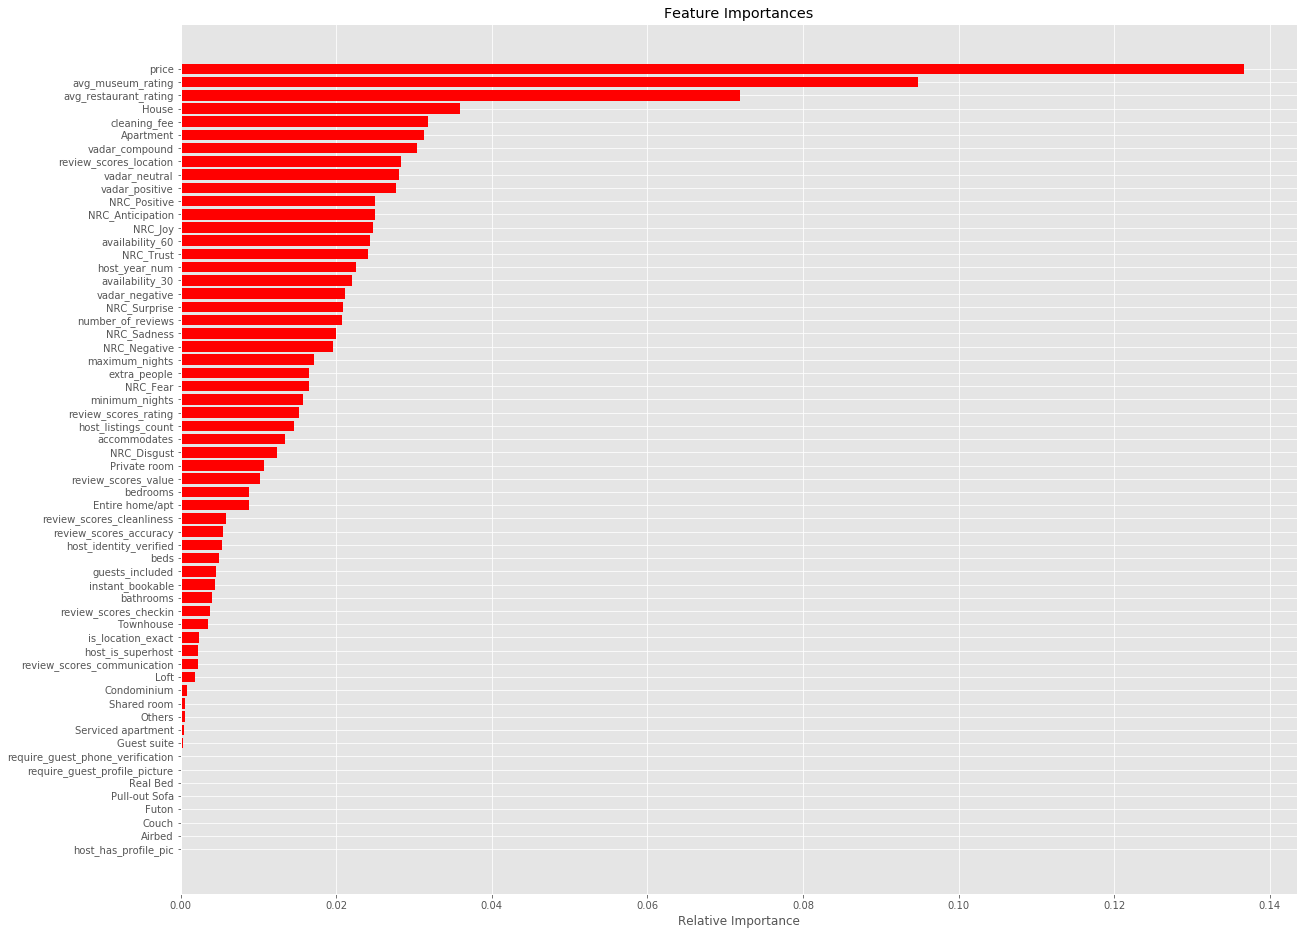

In [87]:
# use dataset with reviews as example for analysis
%matplotlib inline

importances = model_RF1.feature_importances_
indices = np.argsort(importances)
feature_names = model_df_1.drop(['borough'],axis=1).columns

plt.style.use('ggplot')
plt.figure(figsize=(20,16))
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

plt.barh(range(len(indices)), importances[indices], color='R', align='center')
dummy = plt.yticks(range(len(indices)),feature_names[indices])

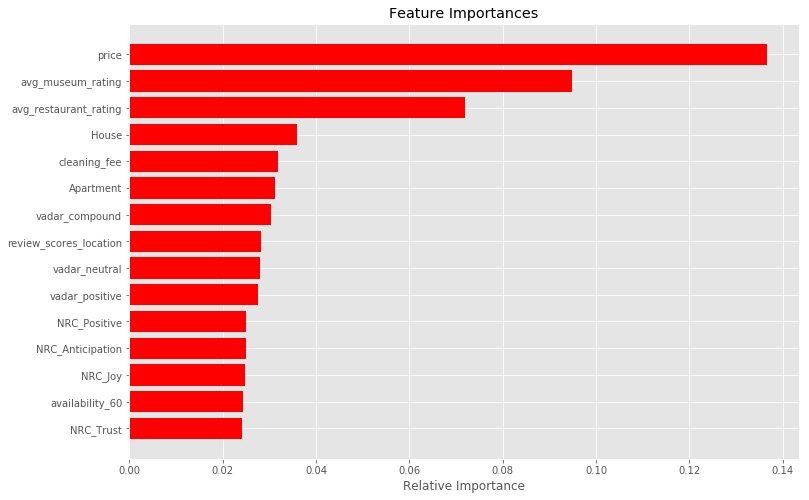

In [88]:
# only plot important features
indice_top = indices[45:]
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.barh(range(len(indice_top)), importances[indice_top], color='R', align='center')
dummy = plt.yticks(range(len(indice_top)),feature_names[indice_top])

## Further exploratory analysis
- if only select important features
    - re-compute with random forest and logistic regression
    - compare with accuracy before drop irrelavant features

In [81]:
col_num = 20
model_df_4 = one_hot_model.drop(feature_names[indices][:-col_num],axis=1)
model_df_4.dropna(inplace=True)
model_df_4.head()

,borough,price,cleaning_fee,availability_30,availability_60,number_of_reviews,review_scores_location,host_year_num,vadar_positive,vadar_negative,...,vadar_compound,NRC_Trust,NRC_Positive,NRC_Joy,NRC_Anticipation,NRC_Surprise,avg_museum_rating,avg_restaurant_rating,Apartment,House
listing_id,,,,,,,,,,,,,,,,,,,,,
2515,1,19.666667,20.000000,10,22,173,9.0,10,0.221300,0.019026,...,0.365536,0.023872,0.034077,0.018405,0.015216,0.007016,3.40,4.02,1,0
2539,2,37.250000,6.250000,25,55,8,10.0,10,0.290750,0.009437,...,0.499075,0.038647,0.062802,0.028986,0.028986,0.009662,3.10,4.26,1,0
3330,2,35.000000,62.500000,1,1,34,10.0,10,0.245543,0.008633,...,0.448850,0.030272,0.044063,0.026236,0.020518,0.008745,2.80,4.14,1,0
3831,2,29.666667,21.505799,0,0,213,9.0,10,0.214805,0.018656,...,0.363554,0.024736,0.038644,0.019894,0.019014,0.008627,2.65,4.44,0,0
5022,1,80.000000,80.000000,0,11,7,9.0,9,0.245000,0.005852,...,0.441030,0.016092,0.032184,0.011494,0.016092,0.009195,3.20,4.12,1,0


In [57]:
model_RF4,score_RF4 = random_forest(model_df_4,n_estimators=round(col_num*0.7),max_depth=10,min_samples_split=8,min_samples_leaf=8)
print('\n')
model_LR4,score_LR4 = logistic_regression(model_df_4)

Random forest accuracy: 0.6664526190257775
Parameters:
n_estimators: 14 
max_depth: 10 
min_samples_split: 8 
min_samples_leaf: 8


Logistic regression accuracy: 0.6072837354371159


In [ ]:
model_SVM4,score_SVM4 = Support_Vector_Machine(model_df_4,'rbf',10)

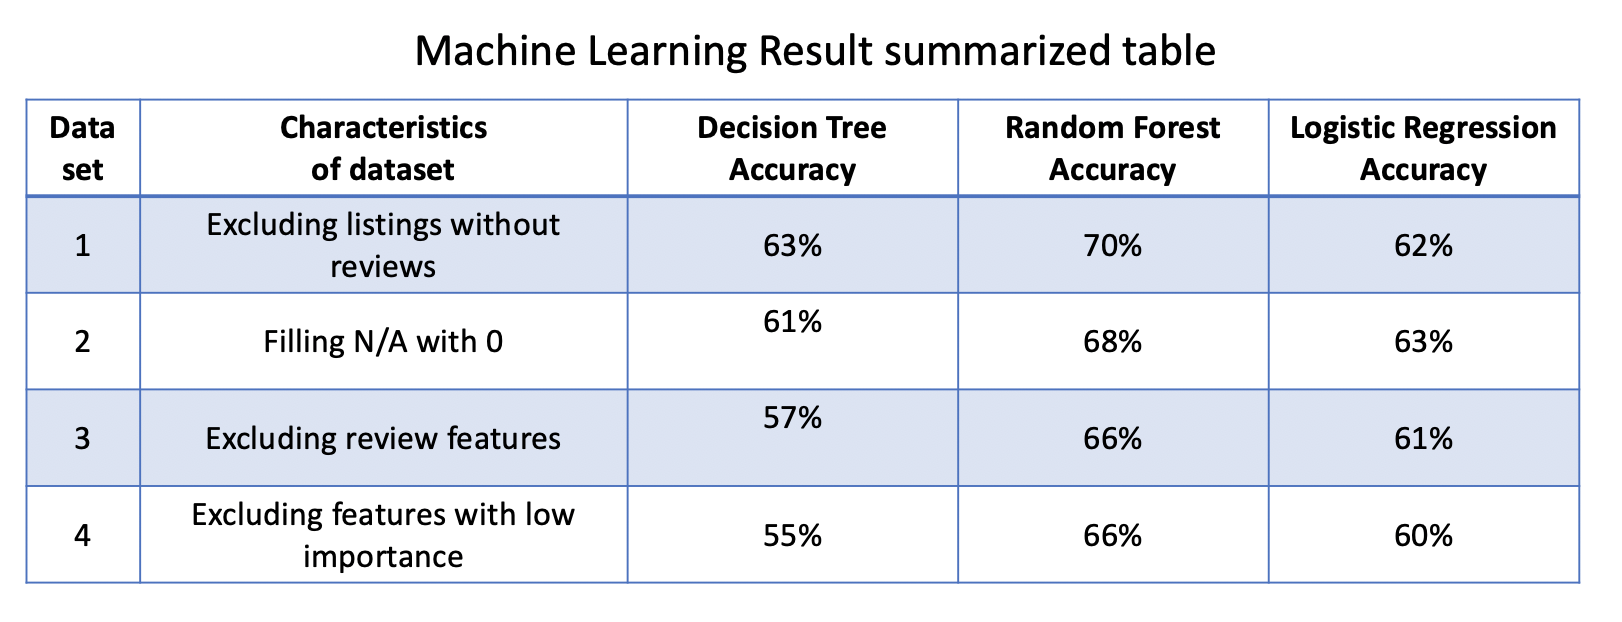

In [86]:
# summarized ml result
Image(filename = 'ML_result_table.png', width=800, height=400)

### Conclusion: 
- Logistic regression works best when not excluding values (dataset 2)
- Random forest has higher tolerance with missing values (all datasets)
- Eliminating non-important features doesn't really help increase the model accuracy (dataset 3 and dataset 4)

# Recommendations

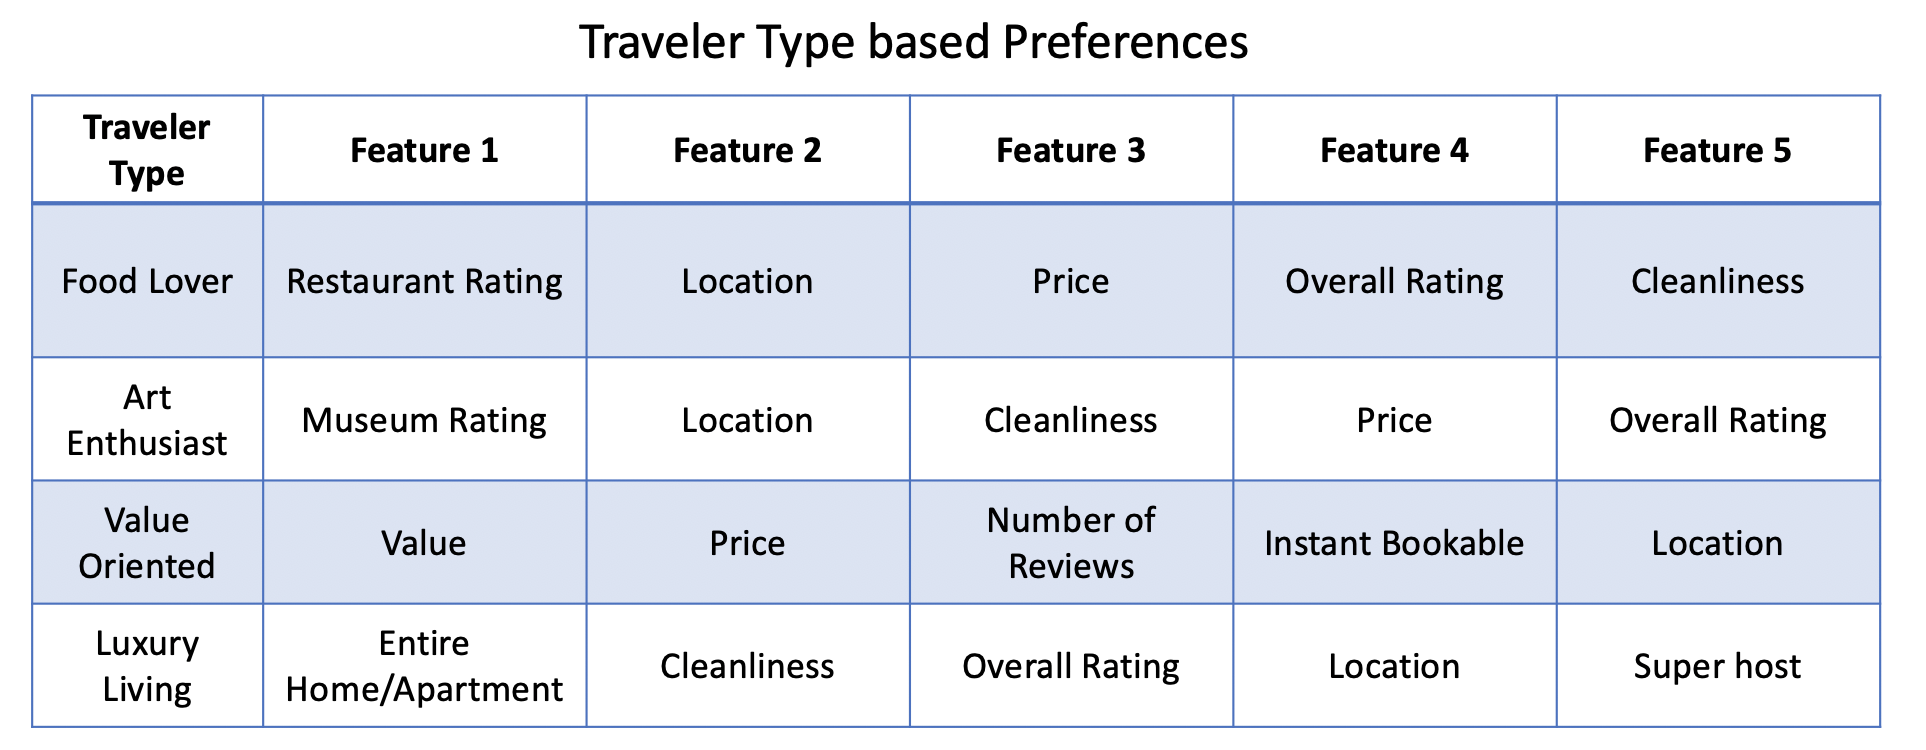

In [89]:
Image(filename = 'Traveler_type_preferences.png', width=800, height=400)